# Simple TDE Filter

Search for several broad line emission features characteristic of TDE spectra and select object with all or several of those features. Examples:
1. H$\alpha$ emission.
1. O III $\lambda5007$ line.
1. He II $\lambda4800$ line.
1. etc.

In [ ]:
import os
from glob import glob      # This is used for "wildcard" searches of folders.

from abc import ABC

from astropy.table import Table

from desispec.io import read_spectra
from desispec.spectra import stack as specstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import statistics

import sys




## Access to Tile ToO from JuTy 2021

This is a dummy data set we'll use as a sandbox to test the TDE filter.

In [3]:
redux = 'daily/tiles/cumulative'
basedir = os.environ['DESI_SPECTRO_REDUX']

tiles = ['80980', '80981']
tiledate = '20210708'

spectra = None
# Loop over all tiles in our tile list.
for tile in tiles:
    tilefolder = '{}/{}/{}/{}'.format(basedir, redux, tile, tiledate)
    coadds = sorted(glob('{}/coadd*.fits'.format(tilefolder)))
    
    # Loop over all petals in the spectroscopic reduction.
    for coadd in coadds:
        # Read the spectra and the best-fit redshifts from redrock and combine into one stack of spectra.
        spec = read_spectra(coadd)
        zbest_files = coadd.replace('coadd', 'zbest')
        zbest = Table.read(zbest_files, 'ZBEST')
        spec.extra_catalog = zbest

        # Accumulate spectra from all petals into one object, "spectra."
        if spectra is None:
            spectra = spec
        else:
            spectra = specstack([spectra, spec])
        
        break
    break
            
zbest = spectra.extra_catalog

INFO:spectra.py:282:read_spectra: iotime 29.110 sec to read coadd-0-80980-thru20210708.fits at 2021-08-16T13:15:34.128128


### Select Quality Redshifts

Select spectra with good redshifts according to redrock. We'll use this to move to the objects' restframes and look for TDE-like spectra lines.

In [9]:
select = (zbest['DELTACHI2']>25) & (zbest['ZWARN']==0) & (zbest['Z']<=0.75)

In [10]:
spectra = spectra[select]

In [11]:
spectra.num_spectra()

301

{'prominences': array([42.10678196, 36.95031166, 43.9591918 , 55.03142667, 24.08481407,
        37.81577873, 33.04949379]),
 'left_bases': array([ 295,  361,  419,  462,  926,  926, 1577]),
 'right_bases': array([2472, 2472,  462, 2472, 1005, 2472, 2472]),
 'widths': array([ 14.13036178,  11.47884602,  32.79524467, 160.0494761 ,
         22.86566744, 254.7370474 , 318.69834969]),
 'width_heights': array([36.87179899, 39.08056927, 24.59338307, 29.08710039, 39.94923496,
        36.48761082, 34.12539577]),
 'left_ips': array([ 302.42200758,  384.5062453 ,  421.88865818,  466.4050197 ,
         943.08618485, 1166.25942572, 1580.29384374]),
 'right_ips': array([ 316.55236936,  395.98509132,  454.68390284,  626.4544958 ,
         965.95185228, 1420.99647312, 1898.99219343])}

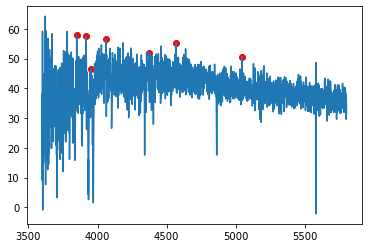

In [63]:
k = 5
plt.plot(spectra.wave['b'], spectra.flux['b'][k])
peaks, info = scipy.signal.find_peaks(spectra.flux['b'][k], prominence=0, width=10)
plt.scatter(spectra.wave['b'][peaks], spectra.flux['b'][k][peaks], color='r')
info

array([ 312,  395,  443,  575,  965, 1211, 1806])

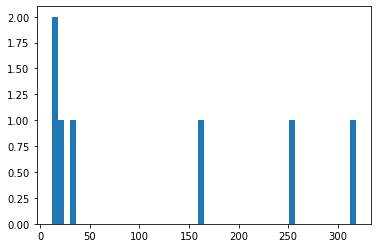

In [47]:
plt.hist(info['widths'], bins=50)
peaks

## TDE Filtering Code

In [99]:
# Search code implemented as a class.
def gauss2(x, b, a, x0, sigma):
    """Implementation of 1D Gaussian with arbitrary normalization.
    
    Parameters
    ----------
    x : ndarray
        List of independent values (ordinates) where we perform the fit.
    b : float
        Free parameter: constant offset.
    a : float
        Free parameter: normalization.
    x0 : float
        Location parameter of the Gaussian.
    sigma : float
        Scale parameter (width) of the Gaussian.
    
    Returns
    -------
    y : ndarray
        Gaussian function N(x|a,b,x0,sigma) evaluated for all x.
    """
    return b + (a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))

class TDEFilter:
    
    def __init__(self):
        self.heii_line_range = [4670., 4700.]
        self.oiii_line_range = [4992., 5022.]
        self.halpha_line_range = [6540., 6570.]
        
    def get_peak_in_range(self, wave, flux, wrange, prom=0, width=10):
        # Pick out the desired wavelength subrange of the spectrum.
        wmin, wmax = wrange
        i, j = 0, len(wave)   # TEMPORARY: DELETE AFTER TESTING!
#         i = np.abs(wmin - wave).argmin()
#         j = np.abs(wmax - wave).argmin()
        
        # Apply the scipy peak finder to the subarray.
        peaks, info = scipy.signal.find_peaks(flux[i:j], prominence=prom, width=width)

        if len(peaks) > 0:
            # Pick out the maximum flux in this range (eliminates noise/local minima).
            k = flux[peaks].argmax()
            peakidx = peaks[k]
            peakflux = flux[peakidx]
            peakwave = wave[peakidx]
            peakwidth = info['widths'][k]
            return peakidx, peakwave, peakwidth, peakflux

        return None
    
    def snip_data_near_peak(self, wave, flux, good_peak, good_width):
        # Extract a range of values in pixel space (2.2*peak finder width).
        peak_edge = int(np.floor(2.2*(good_width)))
        i = np.maximum(0, good_peak - peak_edge)
        j = np.minimum(len(wave), good_peak + peak_edge)
        
        return wave[i:j], flux[i:j]
    
    def is_tde(self, wave, flux):
        
        # Call the peak finder for the spectrum.
        peakinfo = self.get_peak_in_range(wave, flux, self.heii_line_range)
        if peakinfo is not None:
            # Extract a range around the peak.
            print(peakinfo)
            peakidx, peakwave, peakwidth, peakflux = peakinfo
            subwave, subflux = self.snip_data_near_peak(wave, flux, peakidx, peakwidth)
        
            # Fit the feature to a 1D Gaussian.
            pars, cov = curve_fit(gauss2, subwave, subflux, p0=[1., peakflux, peakwave, peakwidth])
            print(pars)
            
        # Try to identify the TDE-like features.
        
        # Return true if the features are present in a certain arrangement.
        
        return True

In [100]:
tdefilt = TDEFilter()
tdefilt.is_tde(spectra.wave['b'], spectra.flux['b'][k])

(312, 3849.6000000000568, 14.130361779775285, 57.92518997192383)
[  29.12172485   15.035281   3860.94457385   15.02400483]


True

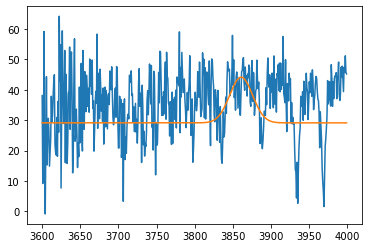

In [106]:
plt.plot(spectra.wave['b'][0:500], spectra.flux['b'][k][0:500])

pars = [  29.12172485,   15.035281,   3860.94457385,   15.02400483]

plt.plot(spectra.wave['b'][0:500], gauss2(spectra.wave['b'], *pars)[0:500])

In [ ]:
# Defining the most important parts of the peak finder algorithm.

def gauss2(x, b, a, x0, sigma):
    """Implementation of 1D Gaussian with arbitrary normalization.
    
    Parameters
    ----------
    x : ndarray
        List of independent values (ordinates) where we perform the fit.
    b : float
        Free parameter: constant offset.
    a : float
        Free parameter: normalization.
    x0 : float
        Location parameter of the Gaussian.
    sigma : float
        Scale parameter (width) of the Gaussian.
    
    Returns
    -------
    y : ndarray
        Gaussian function N(x|a,b,x0,sigma) evaluated for all x.
    """
    return b + (a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
    
def sub_list_into_max(thelist, flux):
    """Basically, return arg max(flux[j]), where j indexes local maxima.
    
    Parameters
    ----------
    thelist : ndarray of int
        Index of values used to search.
    flux : ndarray of float
        List of local maxima in the flux.
    
    Returns
    -------
    argmax : int
        Index of the global maximum out of the list of local maxima.
    """
    maximum = 0
    max_index = 0
    for k in range(len(thelist)):
        if flux[thelist[k]] > maximum:
            maximum = flux[thelist[k]]
            max_index = k
    return max_index

def has_peak_in_range(wave,flux,prom,wid,minwave,maxwave):
    """Find a peak (local maximum) in flux vs. wavelength within some wavelength range.
    
    Parameters
    ----------
    wave : ndarray
        Array of input wavelengths in a spectrum.
    
    flux : ndarray
        Flux values in a spectrum.
    
    prom : float
        Topological prominence of the local maximum to find (threshold/cut value).
    
    wid : int or float
        Minimum width (in pixels) identifying a peak.
    
    minwave : float
        Minimum wavelength in search range.
    
    maxwave : float
        Maximum wavelength in search range.
    
    Returns
    -------
    best_peak : int
        Index of the best-fit peak.
    best_width : float
        Width of the best-fit peak.
    """
    # rest wavelength in angstroms, arbitrary flux
    good_peaks = []
    good_widths = []
    peaks, widths = scipy.signal.find_peaks(flux, prominence = prom, width = wid)
    widths = widths["widths"]
    best_peak = None
    best_width = 0
    if len(peaks) != 0:
        for k in range(len(peaks)):
            if (minwave <= wave[peaks[k]]):
                if (wave[peaks[k]] <= maxwave):
                    good_peaks.append(peaks[k])
                    good_widths.append(widths[k])
        if good_peaks == []:
            return best_peak, best_width
        max_index = sub_list_into_max(good_peaks,flux)
        best_peak = good_peaks[max_index]
        best_width = good_widths[max_index]
        return best_peak, best_width
    else:
        return best_peak, best_width
    
def snip_data_near_peak(wave,flux,good_peak,good_width):
    """Given a peak, select a data range for performing a Gaussian fit.
    
    Parameters
    ----------
    wave : ndarray
        Array of input wavelengths in a spectrum.
    
    flux : ndarray
        Flux values in a spectrum.
    
    good_peak : int
        Index (in wave/flux arrays) of peak being fit.
    
    good_width : float
        Width of peak being fit.
    
    Returns
    -------
    snipped_wave : ndarray
        Selected wavelength range around the peak.
    snipped_flux : ndarray
        Selected flux values around the peak.
    """
    peak_edge = math.floor(2.2*(good_width))
    try:
        snipped_wave = wave[good_peak-peak_edge:good_peak+peak_edge]
        snipped_flux = flux[good_peak-peak_edge:good_peak+peak_edge]
    except:
        if (good_peak - peak_edge) < 0:
            snipped_wave = wave[0:good_peak+peak_edge]
            snipped_flux = flux[0:good_peak+peak_edge]
        else:
            snipped_wave = wave[good_peak - peak_edge:len(wave)-1]
            snipped_flux = flux[good_peak - peak_edge:len(wave)-1]
    return snipped_wave,snipped_flux

def fit_gaussian_to_peak(wave,flux,good_peak,good_width):
    """Fit 1D Gaussian to a subselection of a spectrum using a Levenberg-Marquardt minimization.
    
    Parameters
    ----------
    wave : ndarray
        Array of input wavelengths in a spectrum.
    
    flux : ndarray
        Flux values in a spectrum.
    
    good_peak : int
        Index (in wave/flux arrays) of peak being fit.
    
    good_width : float
        Width of peak being fit.
    
    Returns
    -------
    params : list
        List of best-fit 1D Gaussian parameters (xrange, offset, norm, loc, width).
    """
    
    snipped_wave, snipped_flux = snip_data_near_peak(wave,flux,good_peak,good_width)
    params, _ = curve_fit(gauss2, snipped_wave, snipped_flux,p0=[prom,max(snipped_flux),wave[good_peak],wid])
    return params #xrange, offset, height, average, width

def is_TDE(he_params,o_params,h_params):
    """
    Parameters
    ----------
    he_params : list
        wrange, offset, norm, loc, width of He II line.
    o_params : list
        wrange, offset, norm, loc, width of O III line.
    h_params : list
        wrange, offset, norm, loc, width of Halpha line.
    
    Returns
    -------
    is_tde : bool
        If true, sufficient features present for a TDE classification.
    """
    if he_params == []:
        return False
    elif h_params == []:
        return False
    line_ratio = he_params[1]/h_params[1]
    o_ratio = o_params[1]/h_params[1]
    if line_ratio == []:
        return False
    if line_ratio >= 0.9:
        print(line_ratio)
        if o_ratio <= 0.1:
            return True
        elif o_params == []:
            return True
        return False
    return False

# Test to see if the code works for DESI data

In [ ]:
total = sum(select)
prom  = 0
wid = 0

for j in range(sum(select)):
    targetid = spectra.fibermap[select][j]['TARGETID']
    z = spectra.extra_catalog[select][j]['Z']
    smoothed = []
    restwave = []
    good_he_peaks = []
    good_o_peaks = []
    good_h_peaks = []
    good_he_widths = []
    good_o_widths = []
    good_h_widths = []
    for band in spectra.bands:
        smoothed.append(gaussian_filter1d(spectra.flux[band][select][j], 5))
        restwave.append(spectra.wave[band]/(1+z))
    for k in range(len(smoothed)):
        he_peaks,he_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,4670,4700)
        o_peaks,o_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,4992,5022)
        h_peaks,h_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,6540,6570)
        good_he_peaks.extend(he_peaks)
        good_o_peaks.extend(o_peaks)
        good_h_peaks.extend(h_peaks)
        good_he_widths.extend(he_widths)
        good_o_widths.extend(o_widths)
        good_h_widths.extend(h_widths)
    if
        for k in range(len(smoothed)):
            he_params = fit_gaussian_to_peak(restwave,smoothed[k],good_he_peaks,good_he_widths)
            o_params = fit_gaussian_to_peak(restwave,smoothed[k],good_o_peaks,good_o_widths)
            h_params = fit_gaussian_to_peak(restwave,smoothed[k],good_h_peaks,good_h_widths)
        if he_params == []:
            pass
        elif h_params == []:
            pass
        else:
            result = is_TDE(he_params,o_params,h_params)

            if result is True:
                print(targetid)

# Test on TDE.space data

### iPTF16axa from ApJ Screenshot (!)

In [ ]:
dct0613 = Table.read('DCT_0613.csv', names=['wave', 'flux'])
wave = dct0613['wave']
flux = dct0613['flux']

fig, axes = plt.subplots(1,3, figsize=(14,4), tight_layout=True)

ax = axes[0]
ax.plot(wave, flux)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='flux [a.u.]');

ax = axes[1]
ax.plot(wave, wave*flux)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='$\lambda F_\lambda$ [a.u.]');

ax = axes[2]
ax.hist(wave, bins=6, weights=wave*flux, log=True)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='$\lambda F_\lambda$ [a.u.]');

In [ ]:
wave = []
flux = []
new_flux = []
restwave = []
file = open('samplePaperTDE.txt', 'r')

prom  = 0
wid = 0
z = 0.043671

for line in file.readlines():
    currentline = line.rstrip().split("")
    wave.append(float(currentline[0]))
    flux.append(float(currentline[1]))
for k in range(len(flux)):
    new_flux.append(flux[k]*math.pow(10.0,16.0))
    restwave.append(wave[k]/(1+z))
smoothed = [gaussian_filter1d(new_flux, 5)]
good_he_peaks = []
good_o_peaks = []
good_h_peaks = []
good_he_widths = []
good_o_widths = []
good_h_widths = []
he_params = []
o_params = []
h_params = []

for k in range(len(smoothed)):
    he_peaks,he_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,4670,4700)
    o_peaks,o_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,4992,5022)
    h_peaks,h_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,6540,6570)
    good_he_peaks.extend(he_peaks)
    good_o_peaks.extend(o_peaks)
    good_h_peaks.extend(h_peaks)
    good_he_widths.extend(he_widths)
    good_o_widths.extend(o_widths)
    good_h_widths.extend(h_widths)

for k in range(len(smoothed)):
    for j in range(len(good_he_peaks)):
        he_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_he_peaks[j],good_he_widths[j]))
    for j in range(len(good_o_peaks)):
        o_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_o_peaks[j],good_o_widths[j]))
    for j in range(len(good_h_peaks)):
        h_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_h_peaks[j],good_h_widths[j]))

if he_params == []:
    pass
elif h_params == []:
    pass
else:
    result = is_TDE(he_params,o_params,h_params)

    if result is True:
        print('It is a TDE!')
plt.plot(restwave,new_flux)

In [ ]:
lambda_F = []

for k in range(len(restwave)):
    lambda_F.append(new_flux[k]*restwave[k])


In [ ]:

plt.plot(restwave,lambda_F)

In [ ]:
nbins = 30

n, _ = np.histogram(restwave, bins=nbins)
sy, _ = np.histogram(restwave, bins=nbins, weights=lambda_F)
sy2, _ = np.histogram(restwave, bins=nbins, weights=np.multiply(lambda_F,lambda_F))
average = sy/n
std = np.sqrt(sy2/n - average*average)

plt.plot(restwave, lambda_F, 'bo')
plt.errorbar((_[1:] + _[:-1])/2, average, yerr=std, fmt='r-')
plt.show()